### 1. Running Primitive Unified Blocks (PUBs)  (SamplerV2 and EstimatorV2)
For sampling the output of a circuit and estimating the expectation value of an observable


1. Both simple and paramteric circuits are exemplified.

2. The use of Aer Simulator is shown for both sampling and estimating the expectation value

3. Also shown is how to use the IBM quantum computers from their latest cloud platform announced  on July 1, 2025 onwards

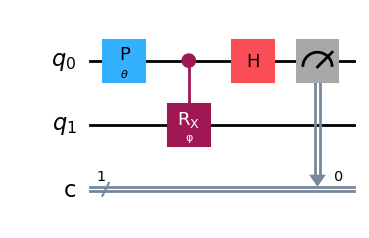

In [1]:

from qiskit.circuit import Parameter
from math import pi
from qiskit import QuantumCircuit

theta = Parameter(r'$\theta$')
phi = Parameter('φ')
qc = QuantumCircuit(2,1)
qc.p(theta,0)
qc.crx(phi,0,1)
qc.h(0)
qc.measure(0,0)
qc.draw('mpl')


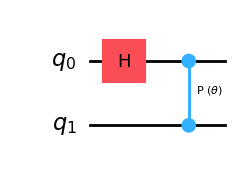

In [2]:
qc = QuantumCircuit(2)    
qc.h(0)
qc.cp(theta,0,1)
qc.draw('mpl')

In [3]:
# PUBs on IBM quantum computers
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
token = "oUN7SN6TvSCQlFRWbhya_F27SJEv8g9G3hWhIbd" # It is the API key. Paste your own key here.
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum_platform", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/2f903a94d6564bd46bda122d:6c4b797f-5ec9-4077-b5fa-b972e20d0::", # Paste your own crn from the Instance section on the dashboard.
  name="Faryad-free-ibm", # Optionally name this set of credentials.
  overwrite=True # Only needed if you already have Cloud credentials.
)

In [4]:
# Load saved credentials if you specified a name
ibm_service = QiskitRuntimeService(name="Faryad-free-ibm")
ibmq_comp = ibm_service.backend('ibm_torino')

In [5]:
from qiskit_aer import AerSimulator
backend_aer = AerSimulator()


In [6]:
sampler_aer = SamplerV2(mode=backend_aer)
sampler_ibm = SamplerV2(mode=ibmq_comp)

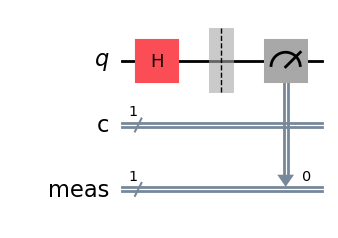

In [7]:
qc1 = QuantumCircuit(1,1)
qc1.h(0)
qc1.measure_all()
qc1.draw('mpl')

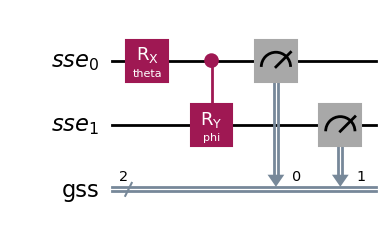

In [8]:
from qiskit import QuantumRegister, ClassicalRegister
qr = QuantumRegister(2, name='sse')
cr = ClassicalRegister(2, name='gss')

qc2 = QuantumCircuit(qr, cr)
qc2.rx(Parameter('theta'), 0)
qc2.cry(Parameter('phi'), 0, 1)
qc2.measure(qr,cr)
qc2.draw('mpl')

In [9]:
qc2.parameters

ParameterView([Parameter(phi), Parameter(theta)])

In [10]:
angles = [[pi/2, pi/4], [pi/3, pi/6], [pi/4, pi/8], [pi/5, pi/10]]

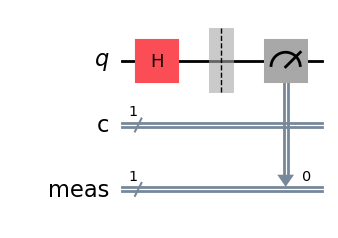

In [11]:
from qiskit import transpile
qc1_aer = transpile(qc1, backend_aer)
qc1_aer.draw('mpl')

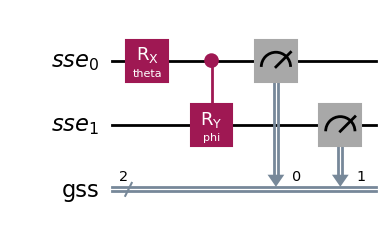

In [12]:
qc2_aer = transpile(qc2, backend=backend_aer)
qc2_aer.draw('mpl')

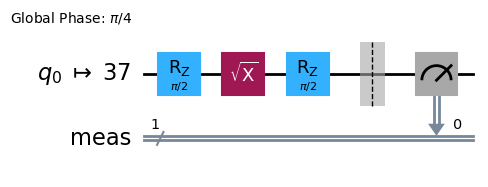

In [13]:
qc1_ibm = transpile(qc1, ibmq_comp)
qc1_ibm.draw('mpl',idle_wires=False)

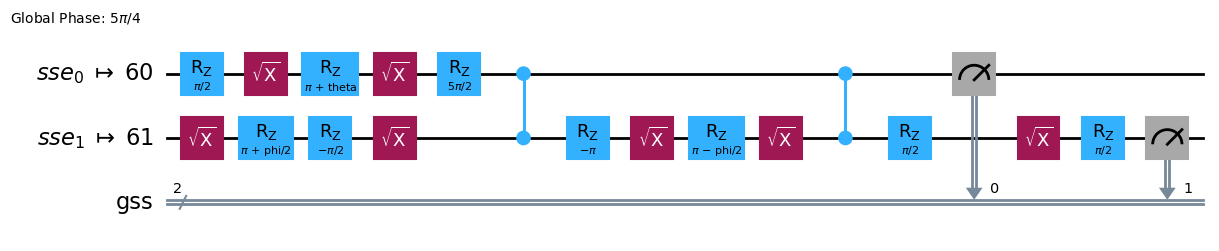

In [14]:
qc2_ibm = transpile(qc2, ibmq_comp)
qc2_ibm.draw('mpl',idle_wires=False)

In [15]:
job_aer = sampler_aer.run([(qc1_aer,None, 100), (qc2_aer,angles,1000)])
job_ibm = sampler_ibm.run([(qc1_ibm,None, 100), (qc2_ibm,angles,1000)])

In [16]:
result_aer = job_aer.result()
result_ibm = job_ibm.result()

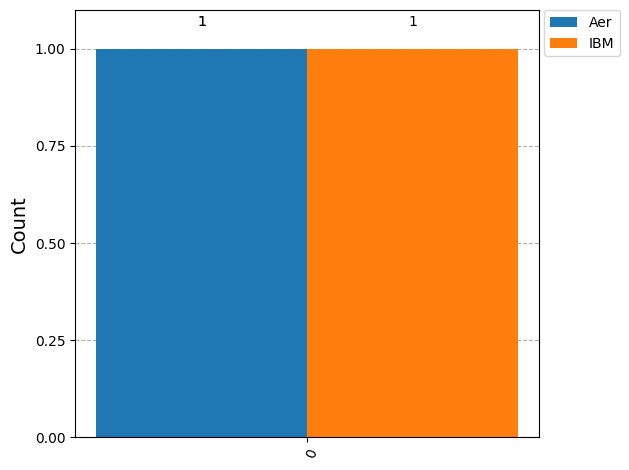

In [17]:
counts_qc1_aer = result_aer[0].data.meas.get_counts(0)
counts_qc1_ibm = result_ibm[0].data.meas.get_counts(0)


from qiskit.visualization import plot_histogram, plot_distribution
plot_histogram([counts_qc1_aer, counts_qc1_ibm], legend=['Aer', 'IBM'])

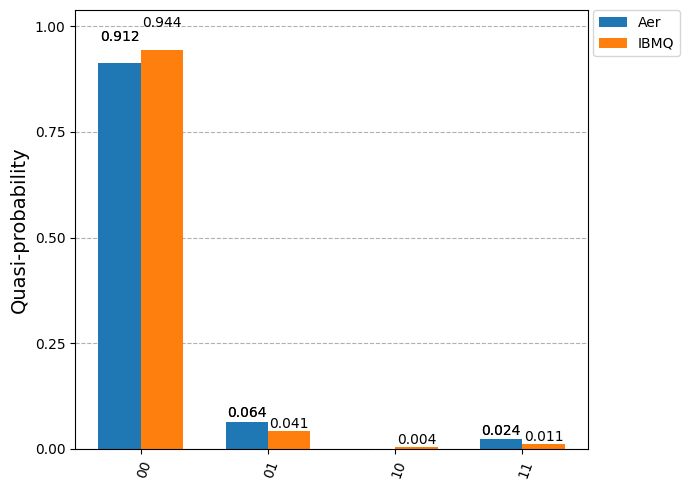

In [18]:
counts_qc2_aer_0 = result_aer[1].data.gss.get_counts(1)
counts_qc2_ibm_0 = result_ibm[1].data.gss.get_counts(1)

plot_distribution([counts_qc2_aer_0, counts_qc2_ibm_0], legend=['Aer', 'IBMQ'])

In [28]:
from qiskit.quantum_info import SparsePauliOp
obsv_list = [[SparsePauliOp(["XX"],[1])],[SparsePauliOp(["ZZ"],[1])]]

In [29]:
layout = qc2_ibm.layout

obsv_ibm = [[obsv_list[0][0].apply_layout(layout)],[obsv_list[1][0].apply_layout(layout)]]
obsv_ibm

[[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
                coeffs=[1.+0.j])]]

In [30]:

estimator_aer = EstimatorV2(mode=backend_aer)
estimator_ibm = EstimatorV2(mode=ibmq_comp)

In [31]:
job2_aer = estimator_aer.run([(qc2_aer,obsv_list,angles, 0.005)])
job2_ibm = estimator_ibm.run([(qc2_ibm,obsv_ibm,angles, 0.005)])

In [32]:
exp_vals_aer = job2_aer.result()[0].data.evs
print(exp_vals_aer)

[[0.00905 0.00265 0.00185 0.00125]
 [0.85105 0.9021  0.93385 0.95755]]


In [33]:
#job2_ibm=QiskitRuntimeService().job('csy5rwbe88ng008q7bc0')

In [34]:
exp_vals_ibm = job2_ibm.result()[0].data.evs
print(exp_vals_ibm)

[[0.00465132 0.0057883  0.00723538 0.00428955]
 [0.84126791 0.88865964 0.92524999 0.94204641]]


In [35]:
job2_aer.result()[0].data.stds

array([[0.0049998 , 0.00499998, 0.00499999, 0.005     ],
       [0.00262542, 0.00215764, 0.00178832, 0.00144134]])

In [36]:
job2_ibm.result()[0].data.stds

array([[0.00588461, 0.00544497, 0.00452308, 0.00503614],
       [0.00365216, 0.0029994 , 0.00278544, 0.00231061]])